### Paths

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

import tldextract
import re

In [11]:
sys.path.append(os.path.abspath('../../src'))

from helper_functions.path_resolver import DynamicPathResolver, read_wordbag
from helper_functions import visualization as visual

### Paths

In [12]:
resolver = DynamicPathResolver(marker="README.md")
structure = resolver.structure

raw_data_path = structure.data.raw.data_url.phishing_url_csv

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


### Load data

In [13]:
url_df = pd.read_csv(raw_data_path)
url_df.head()

,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0


### Basic info

In [14]:
print(f"Shape: {url_df.shape}\n")
print(f"Missing values:\n{url_df.isnull().sum()}\n")
print(f"Class distribution:\n{url_df['status'].value_counts()}\n")

Shape: (822010, 2)

Missing values:
url       0
status    0
dtype: int64

Class distribution:
status
1    427028
0    394982
Name: count, dtype: int64



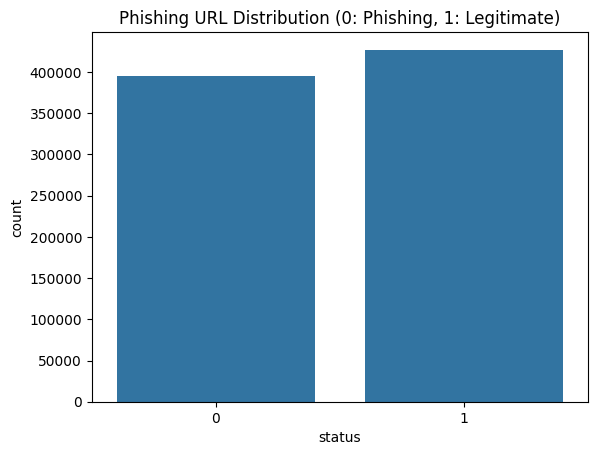

In [15]:
visual.plot_countplot(url_df, 'status', 'Phishing URL Distribution (0: Phishing, 1: Legitimate)')

### Extract features

In [16]:
def get_protocol(url):
    if url.startswith('https://'):
        return 'https'
    elif url.startswith('http://'):
        return 'http'
    else:
        return 'none'
        
def extract_url_features(df, phishing_words):
    extracted_tlds = df['url'].apply(lambda x: tldextract.extract(x))
    df['subdomain'] = extracted_tlds.apply(lambda x: x.subdomain)
    df['domain'] = extracted_tlds.apply(lambda x: x.domain)
    df['tld'] = extracted_tlds.apply(lambda x: x.suffix)
    
    df['protocol'] = df['url'].apply(get_protocol)
    df['is_https'] = df['protocol'] == 'https'
    df['is_http'] = df['protocol'] == 'http'
    df['is_none'] = df['protocol'] == 'none'
    df['contains_phishing_keywords'] = df['url'].apply(lambda x: any(word in x.lower() for word in phishing_words))
    df['has_ip'] = df['url'].apply(lambda x: bool(re.search(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', x)))
    
    return df

In [17]:
phishing_words = read_wordbag(structure.data.raw.wordbags._phishing_terms_txt)
blacklisted_domains = read_wordbag(structure.data.raw.wordbags._blacklisted_domains_txt)

url_df = extract_url_features(url_df, phishing_words)
url_df.head()

,url,status,subdomain,domain,tld,protocol,is_https,is_http,is_none,contains_phishing_keywords,has_ip
0,0000111servicehelpdesk.godaddysites.com,0,0000111servicehelpdesk,godaddysites,com,none,False,False,True,True,False
1,000011accesswebform.godaddysites.com,0,000011accesswebform,godaddysites,com,none,False,False,True,True,False
2,00003.online,0,,00003,online,none,False,False,True,False,False
3,0009servicedeskowa.godaddysites.com,0,0009servicedeskowa,godaddysites,com,none,False,False,True,False,False
4,000n38p.wcomhost.com,0,000n38p,wcomhost,com,none,False,False,True,False,False


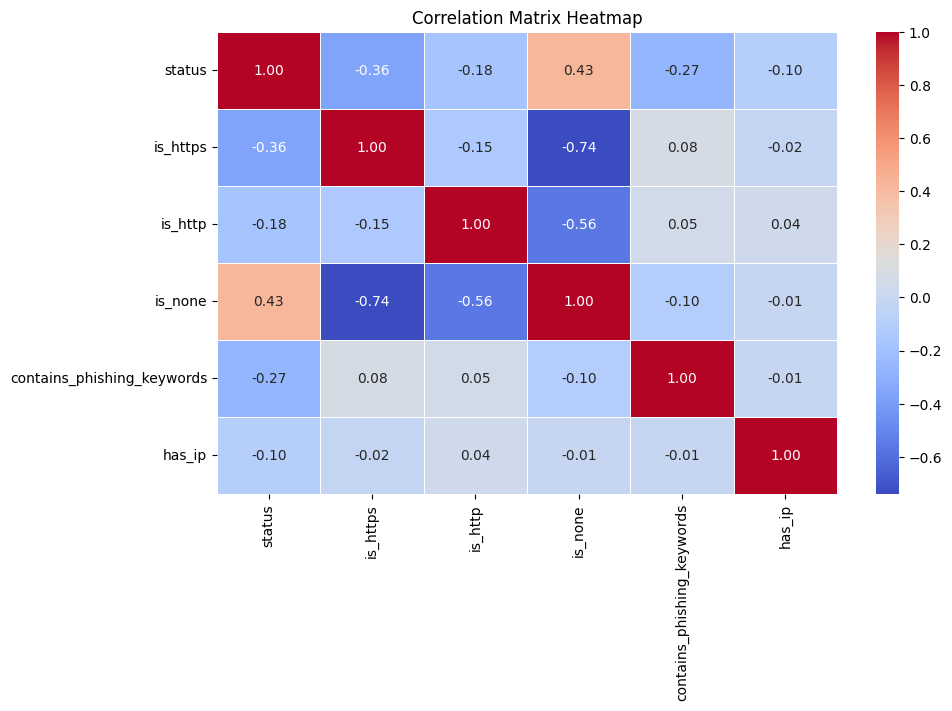

In [18]:
numeric_cols = ['status', 'is_https', 'is_http', 'is_none', 'contains_phishing_keywords', 'has_ip']
visual.plot_correlation_heatmap(df=url_df, numeric_cols=numeric_cols, title='Correlation Matrix Heatmap')

### Top frequent Subdomains, Domains, TLDs

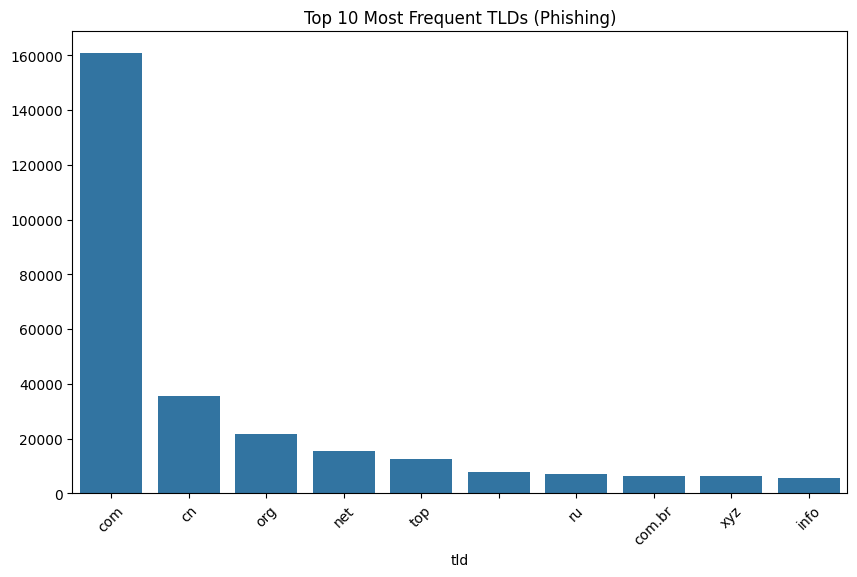

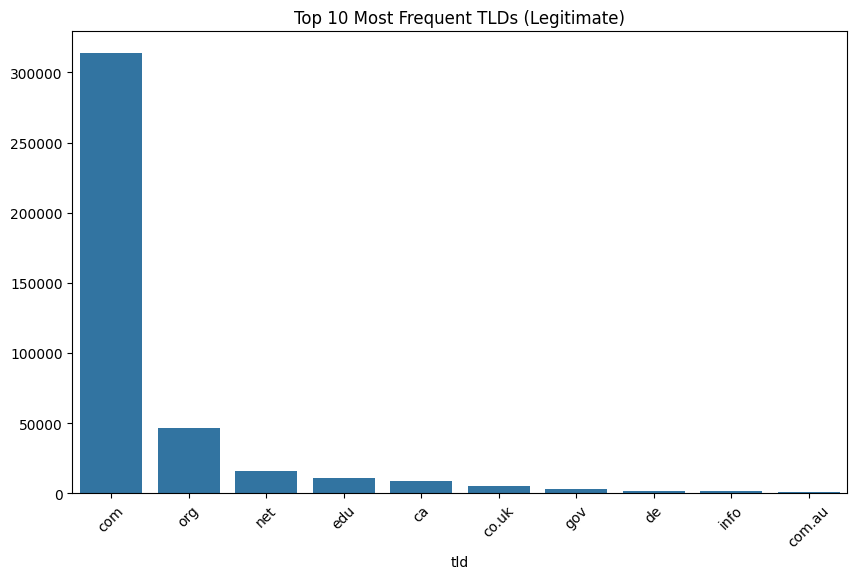

In [19]:
# Phishing
phishing_tld_counts = url_df[url_df['status'] == 0]['tld'].value_counts().head(10)
visual.plot_bar(phishing_tld_counts, 'Top 10 Most Frequent TLDs (Phishing)', xlabel_rotation=45)

# Legitimate
legitimate_tld_counts = url_df[url_df['status'] == 1]['tld'].value_counts().head(10)
visual.plot_bar(legitimate_tld_counts, 'Top 10 Most Frequent TLDs (Legitimate)', xlabel_rotation=45)


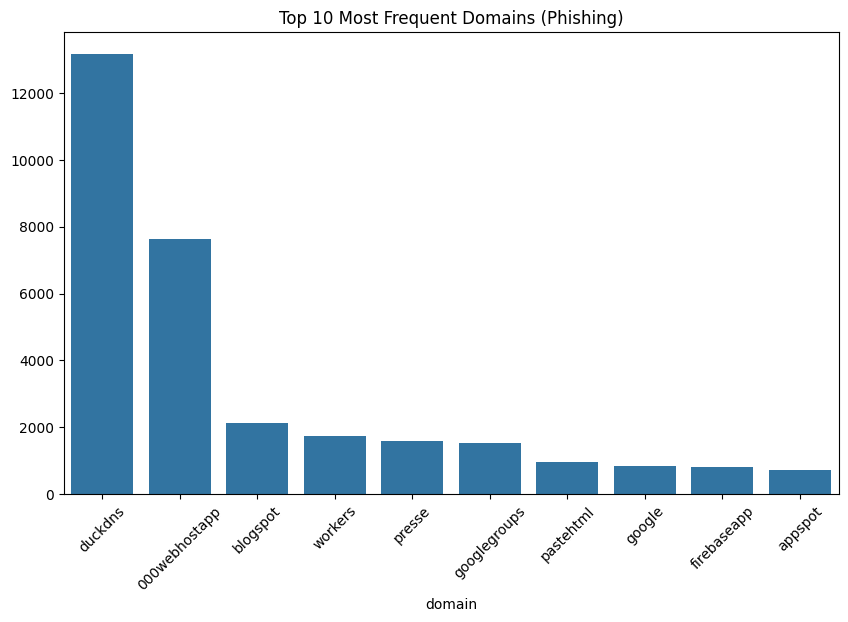

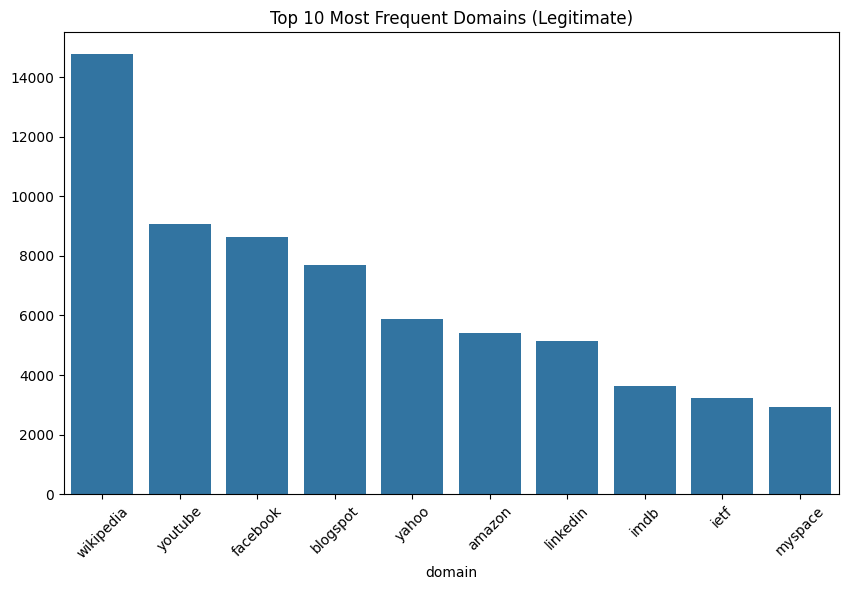

In [20]:
# Phishing
phishing_domain_counts = url_df[url_df['status'] == 0]['domain'].value_counts().head(10)
visual.plot_bar(phishing_domain_counts, 'Top 10 Most Frequent Domains (Phishing)', xlabel_rotation=45)

# Legitimate
legitimate_domain_counts = url_df[url_df['status'] == 1]['domain'].value_counts().head(10)
visual.plot_bar(legitimate_domain_counts, 'Top 10 Most Frequent Domains (Legitimate)', xlabel_rotation=45)


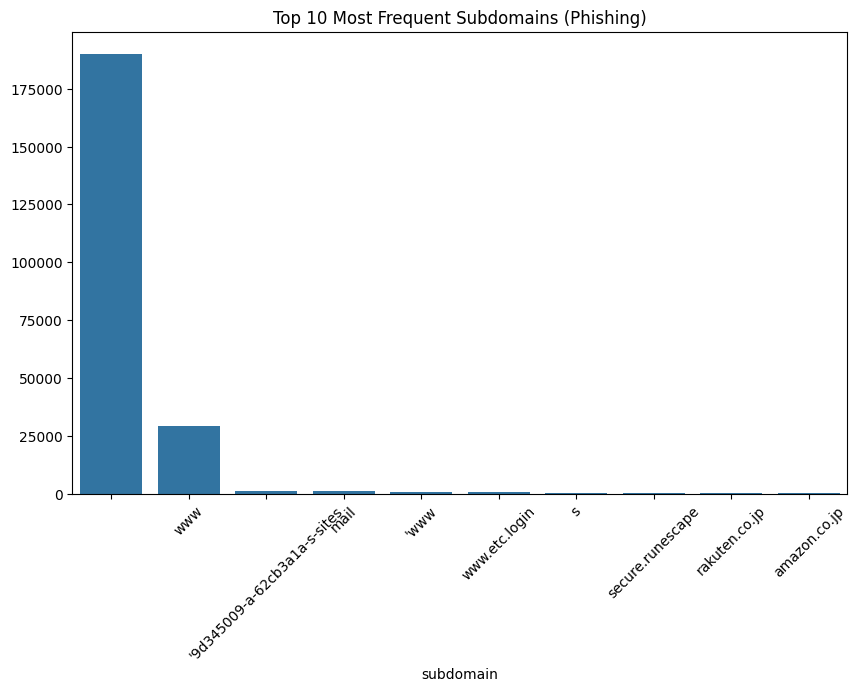

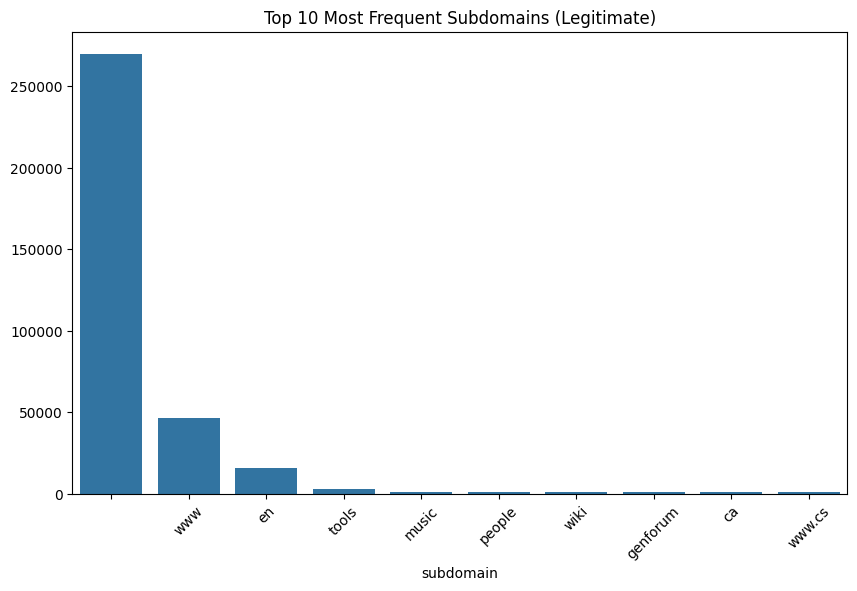

In [21]:
# Phishing
phishing_subdomain_counts = url_df[url_df['status'] == 0]['subdomain'].value_counts().head(10)
visual.plot_bar(phishing_subdomain_counts, 'Top 10 Most Frequent Subdomains (Phishing)', xlabel_rotation=45)

# Legitimate
legitimate_subdomain_counts = url_df[url_df['status'] == 1]['subdomain'].value_counts().head(10)
visual.plot_bar(legitimate_subdomain_counts, 'Top 10 Most Frequent Subdomains (Legitimate)', xlabel_rotation=45)

### HTTP vs. HTTPS

Https by Class:


protocol,http,https,none
status,,,
0,61158,118749,215075
1,20083,14047,392898


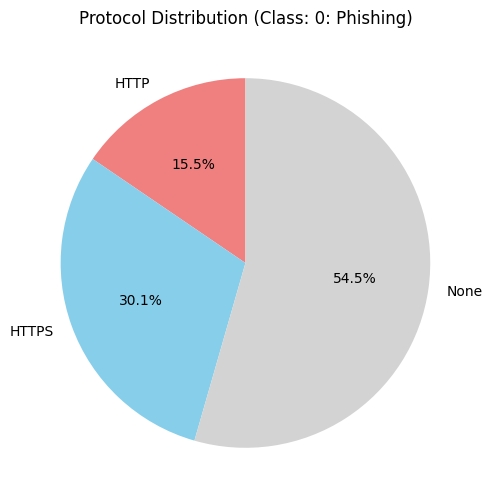

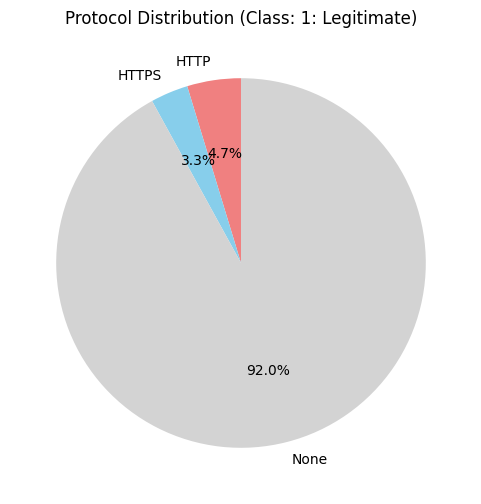

In [22]:
https_by_class = url_df.groupby('status')['protocol'].value_counts().unstack().fillna(0)

print("Https by Class:")
display(https_by_class)

for label, counts in https_by_class.iterrows():
    class_label = "0: Phishing" if label == 0 else "1: Legitimate"
    visual.plot_pie(
        labels=['HTTP', 'HTTPS', 'None'], 
        values=counts.values,
        title=f'Protocol Distribution (Class: {class_label})',
        colors=['lightcoral', 'skyblue', 'lightgray']
    )

### Phishing Terms

Phishing Keywords by Class:


contains_phishing_keywords,False,True
status,,
0,322487,72495
1,416808,10220


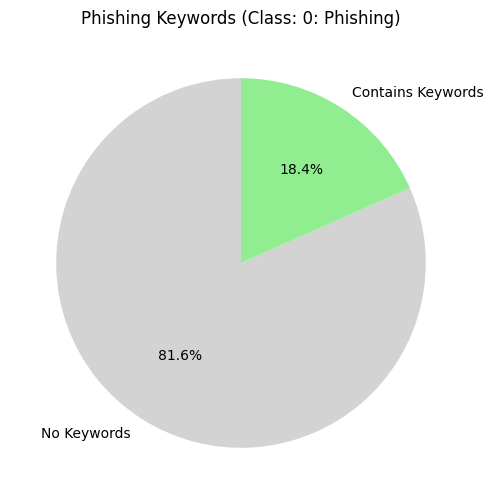

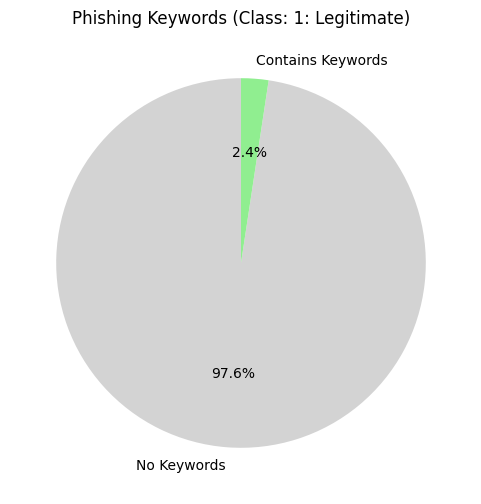

In [23]:
keywords_by_class = url_df.groupby('status')['contains_phishing_keywords'].value_counts().unstack().fillna(0)

print("Phishing Keywords by Class:")
display(keywords_by_class)

for label, counts in keywords_by_class.iterrows():
    class_label = "0: Phishing" if label == 0 else "1: Legitimate"
    visual.plot_pie(
        labels=['No Keywords', 'Contains Keywords'], 
        values=counts.values,
        title=f'Phishing Keywords (Class: {class_label})',
        colors=['lightgray', 'lightgreen']
    )

### Length & Path Analysis

In [24]:
def url_length(url):
    return len(url)

def url_path_depth(url):
    return url.count('/')

In [25]:
url_df['url_length'] = url_df['url'].apply(url_length)
url_df['path_depth'] = url_df['url'].apply(url_path_depth)

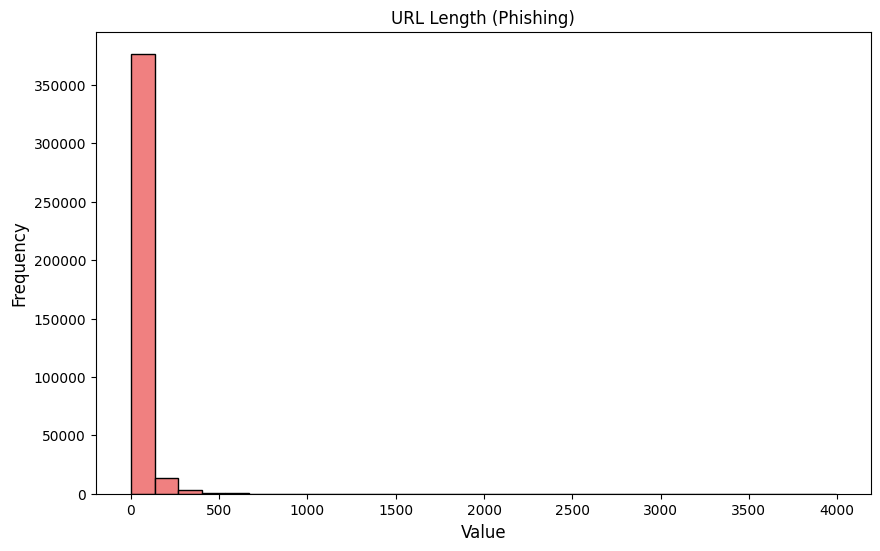

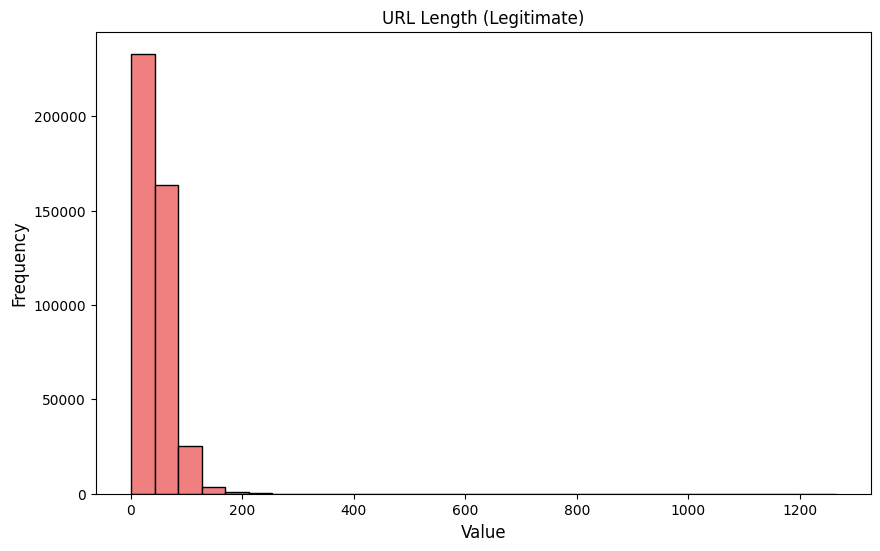

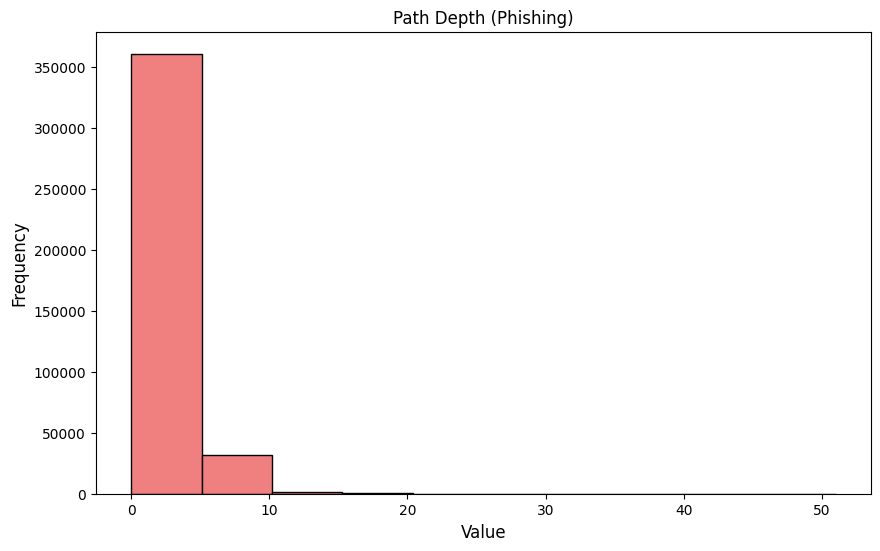

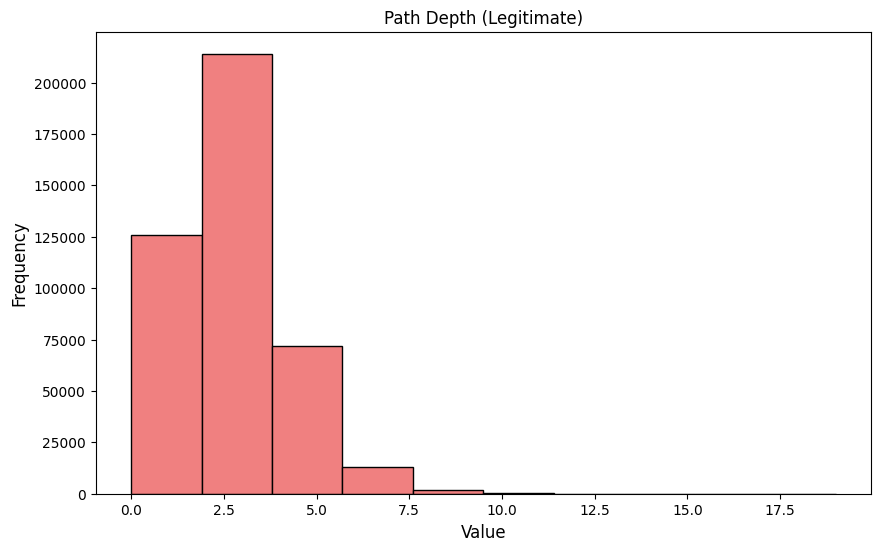

In [26]:
# URL Length Distrobution
visual.plot_histogram(url_df[url_df['status'] == 0]['url_length'], 'URL Length (Phishing)', bins=30)
visual.plot_histogram(url_df[url_df['status'] == 1]['url_length'], 'URL Length (Legitimate)', bins=30)

# Path Depth Distrobution
visual.plot_histogram(url_df[url_df['status'] == 0]['path_depth'], 'Path Depth (Phishing)', bins=10)
visual.plot_histogram(url_df[url_df['status'] == 1]['path_depth'], 'Path Depth (Legitimate)', bins=10)

### URL Encoding

In [27]:
def has_url_encoding(url):
    return '%' in url

url_df['has_url_encoding'] = url_df['url'].apply(has_url_encoding)
encoding_by_class = url_df.groupby('status')['has_url_encoding'].value_counts().unstack().fillna(0)


URL Encoding by Class:


has_url_encoding,False,True
status,,
0,389060,5922
1,416225,10803


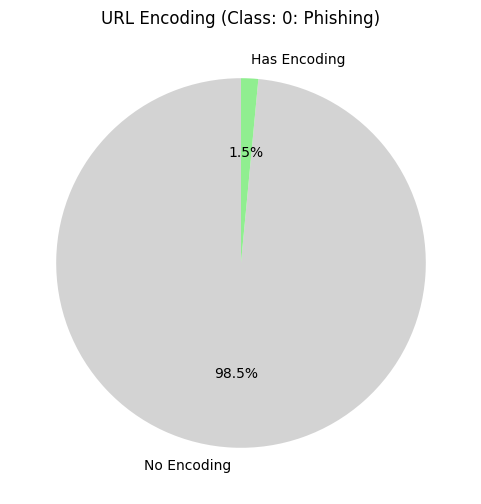

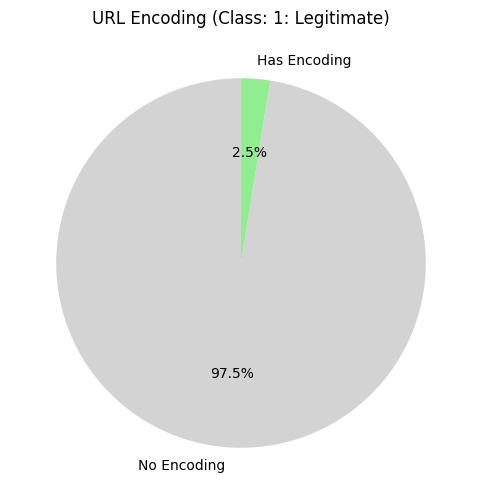

In [28]:
print("URL Encoding by Class:")
display(encoding_by_class)

for label, counts in encoding_by_class.iterrows():
    class_label = "0: Phishing" if label == 0 else "1: Legitimate"
    visual.plot_pie(
        labels=['No Encoding', 'Has Encoding'], 
        values=counts.values,
        title=f'URL Encoding (Class: {class_label})',
        colors=['lightgray', 'lightgreen']
    )


### Char frequeny

In [29]:
def char_frequency(url, char):
    return url.count(char)

chars_to_check = ['/', '@', '.', '%', '-', '=', '?', '&', '=', ':', '_', '#', '!', '~', '*', '$', ';', '+', '(', ')', '[', ']', '{', '}', '|', '\\', '<', '>']

for char in chars_to_check:
    url_df[f'{char}_freq'] = url_df['url'].apply(lambda x: char_frequency(x, char))

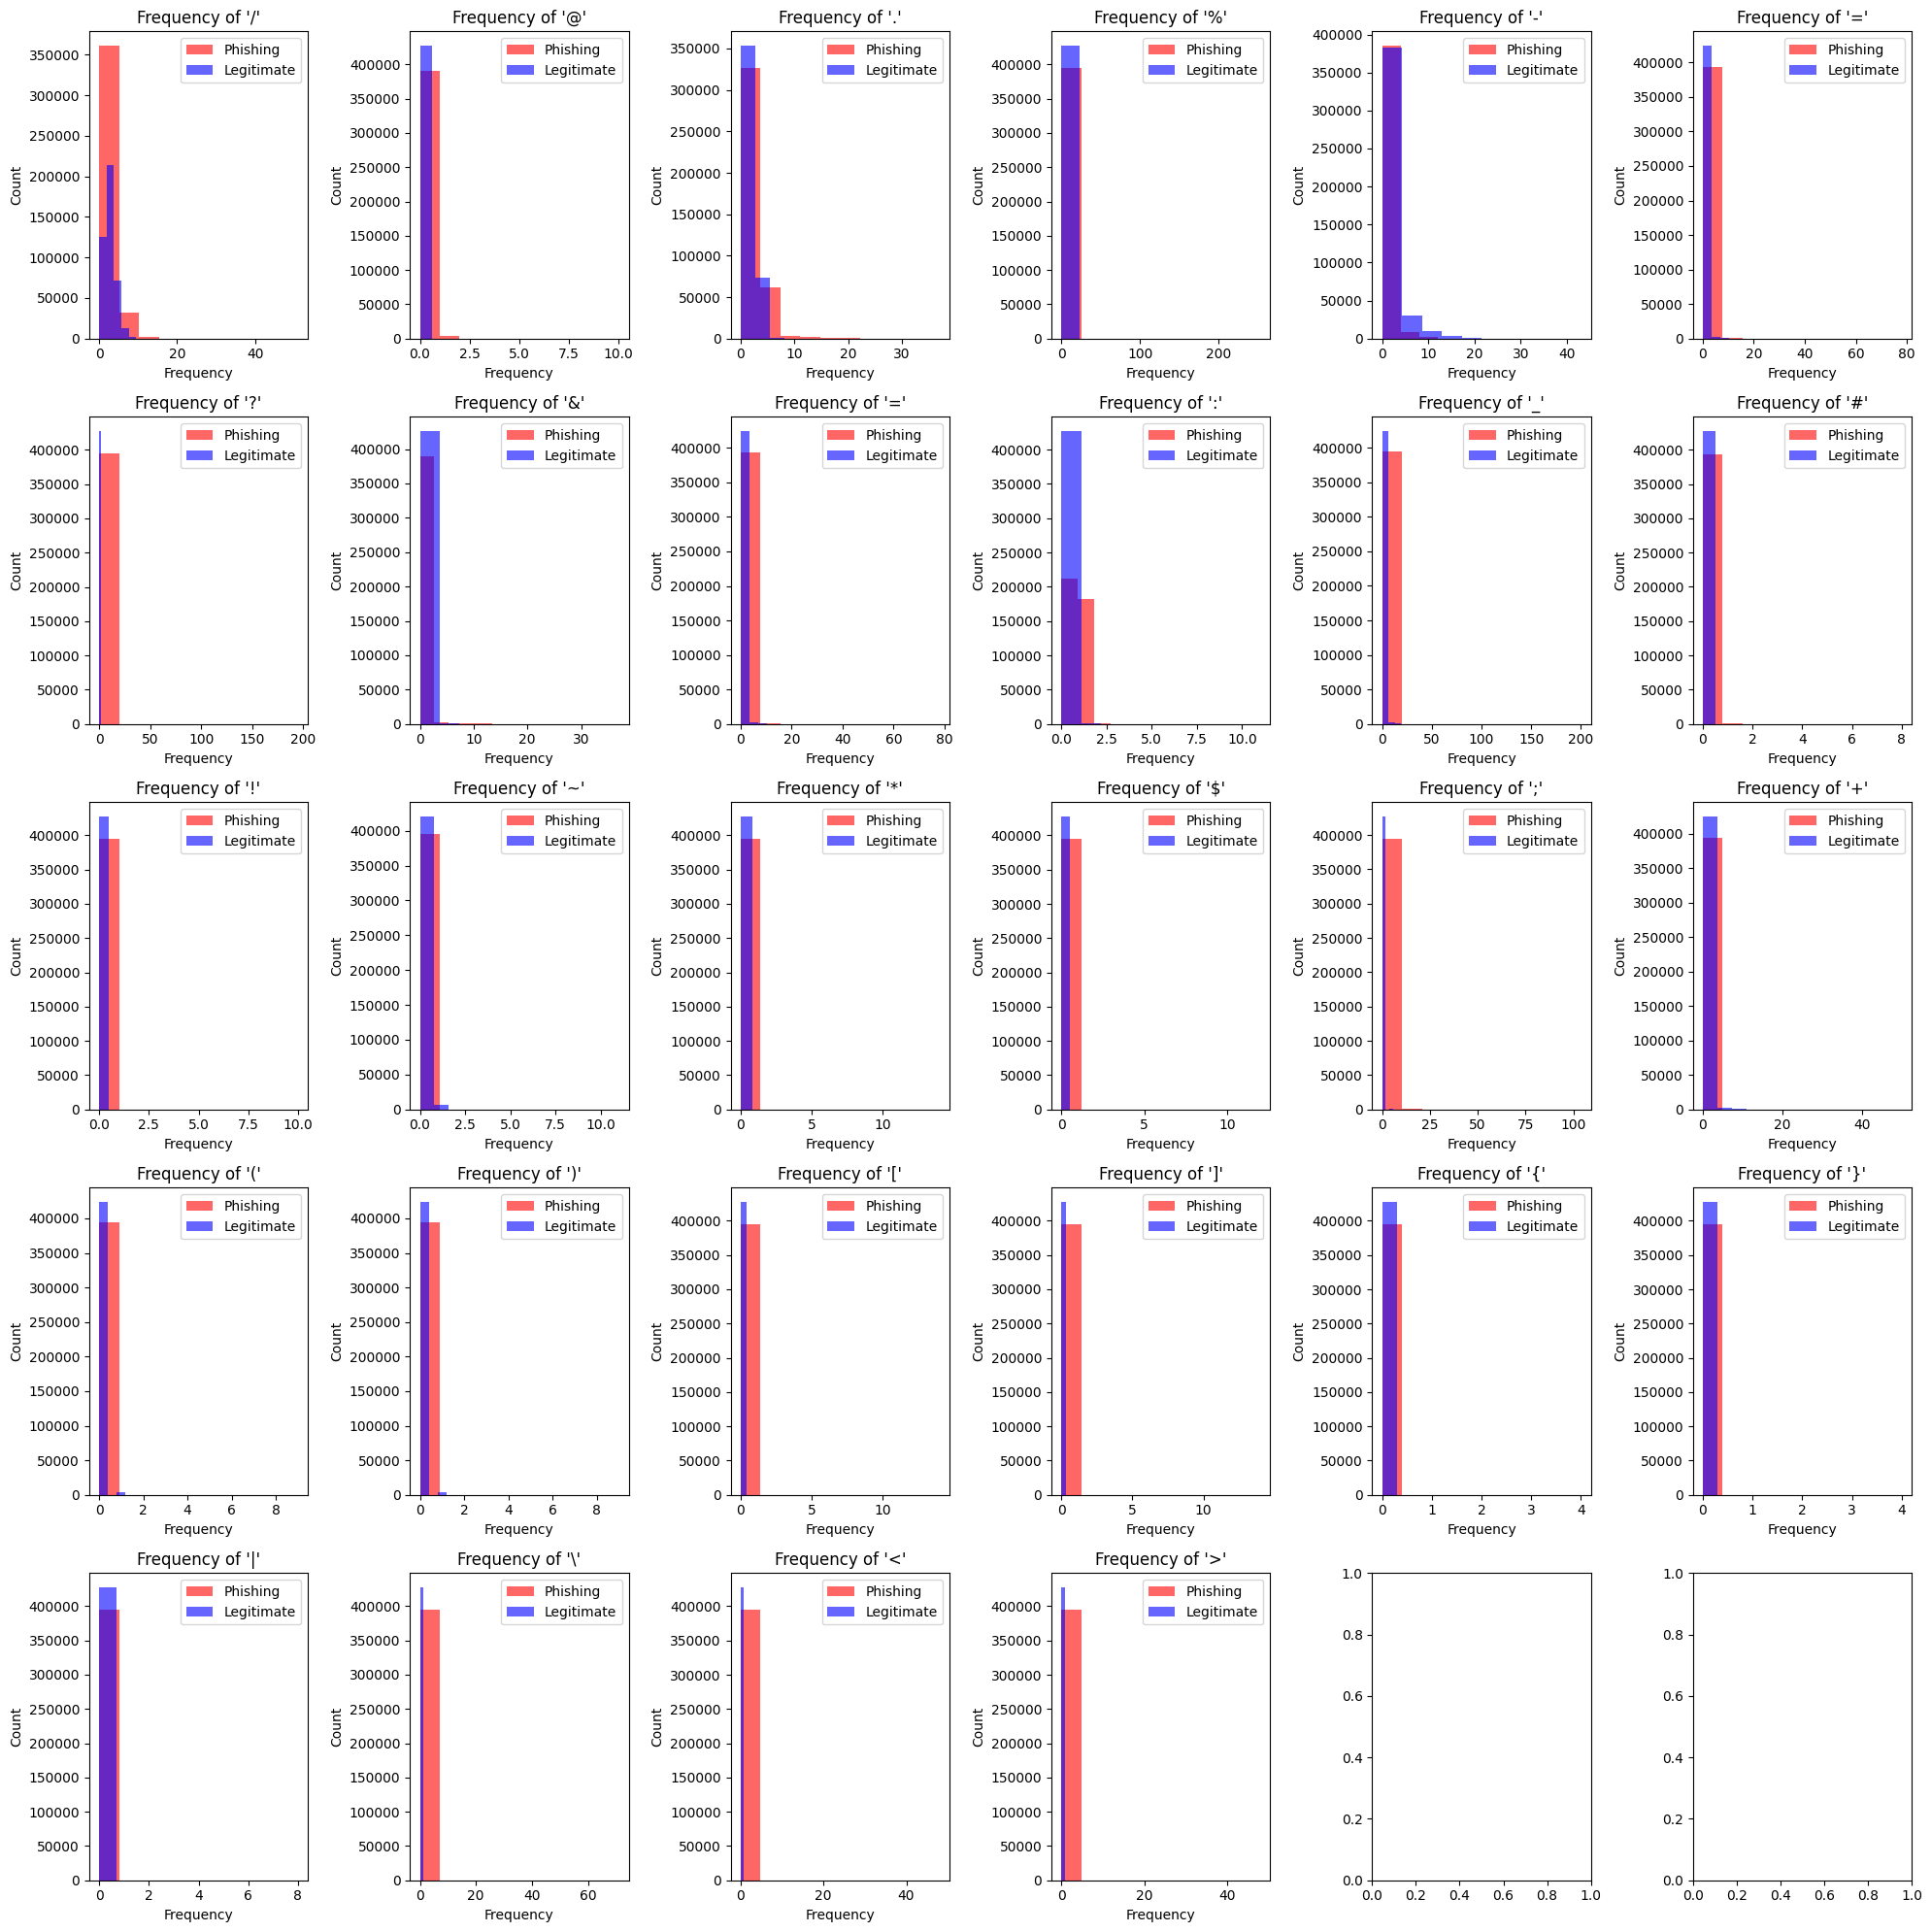

In [30]:
fig, axes = plt.subplots(5, 6, figsize=(20, 20))
axes = axes.flatten()

for i, char in enumerate(chars_to_check):
    phishing_char_freq = url_df[url_df['status'] == 0][f'{char}_freq']
    legitimate_char_freq = url_df[url_df['status'] == 1][f'{char}_freq']

    axes[i].hist(phishing_char_freq, bins=10, alpha=0.6, color='red', label='Phishing')
    axes[i].hist(legitimate_char_freq, bins=10, alpha=0.6, color='blue', label='Legitimate')
    
    axes[i].set_title(f"Frequency of '{char}'")
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()
